In [1]:
import xarray as xr
import numpy as np
import scipy as sp
import seastar as ss
import warnings
import os
from _version import __version__
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from _version import __version__
from datetime import datetime
from scipy.optimize import curve_fit
import matplotlib as mpl
def iqr(da, dim):
    """Calculates interquartile range"""
    return (da.quantile(q=0.75, dim=dim) - da.quantile(q=0.25, dim=dim)).rename("iqr")
SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
version = 'v20230411'
save_folder=os.path.join('D:\data\SEASTAR\SEASTARex\Data\L1_p','')
flights = ['20220522', '20220526']
file_paths = ss.utils.readers._set_file_paths()
file_paths['l1c_path'] = "D:\\data\\SEASTAR\\SEASTARex\\Data\\L1c\\"
L1c_path = os.path.join(file_paths['l1c_path'],'')
DAR_tracks = dict()
DAR_tracks['20220522'] = {
    'Track_11': 3,
    'Track_12': 4,
    'Track_13': 5,
    'Track_14': 6,
    'Track_15': 7,
    'Track_16': 8,
    'Track_17': 9,
    'Track_18': 10,
}

DAR_tracks['20220526'] = {
    'Track_13': 2,
    'Track_14': 3,
    'Track_11': 4,
    'Track_12': 5,
    'Track_17': 6,
    'Track_18': 7,
    'Track_15': 8,
    'Track_16': 9,
}

Device name = LIVPCZG-10
Setting local paths...


# Load flight

In [19]:
version = 'v20230411' # check version
flight = '20220522'
file_paths = ss.utils.readers._set_file_paths()
ds_L1c = dict()
for track in DAR_tracks[flight].keys():
    print('Loading', track)
    ds_L1c[track] = xr.open_dataset(os.path.join(file_paths['l1c_path'],flight + '_' + track + '_OSCAR_L1c.nc'))
    if 'CentralWavenumber' not in ds_L1c[track] and 'CentralFreq' in ds_L1c[track]:
        ds_L1c[track] = ss.oscar.level1.add_central_electromagnetic_wavenumber(ds_L1c[track])
print('...done')
        

Device name = LIVPCZG-10
Setting local paths...
Loading Track_13
Loading Track_14
Loading Track_11
Loading Track_12
Loading Track_17
Loading Track_18
Loading Track_15
Loading Track_16
...done


# Process to L2

In [20]:
folder = 'restricted'
data_type = 'METEOFRANCE_AROME'
AROME_data_folder = os.path.join(file_paths['aux_path'], folder, data_type,'')

AROME_dict = dict()
AROME_file_list = os.listdir(AROME_data_folder)
for file in AROME_file_list:
    AROME_dict[AROME_file_list.index(file)] =\
    xr.open_dataset(AROME_data_folder + file)

AROME_winds = xr.concat(list(AROME_dict.values()),
                        dim='time',
                       join='outer')
del AROME_dict
ds_L2 = dict()
sar_pixel_size=8
rolling_window_metres=8
rolling_window = int(round(rolling_window_metres/sar_pixel_size))
for track in ds_L1c.keys():  
    print('Processing', track)
    # Generating geophysical data fields for GMF doppler computation
    u10 = AROME_winds.u10m.interp(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1c[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1c[track].longitude.median(), method='nearest')
    v10 = AROME_winds.v10m.interp(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1c[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1c[track].longitude.median(), method='nearest')
    wind_speed, wind_direction = ss.utils.tools.windUV2SpeedDir(u10, v10)
    aux = ss.oscar.level1.init_auxiliary(ds_L1c[track].IncidenceAngleImage, wind_speed.data, wind_direction.data)
    # Compute RSC
    rsc = [ss.oscar.level1.compute_radial_surface_current(
        ds_L1c[track].sel(Antenna=a),
        aux.sel(Antenna=a),
        gmf='mouche12'
    ) 
           for a in ds_L1c[track].Antenna]
    ds_L1c[track]['RadialSurfaceCurrent'] = xr.concat(rsc, 'Antenna',join='outer')
    #L2 Processing
    # Initialise l2 dataset
    ds_L2[track] = ss.oscar.level1.init_level2(ds_L1c[track])
    # Compute current magnitude and direction
    ds_L2[track] = ss.retrieval.level2.compute_current_magnitude_and_direction(ds_L1c[track], ds_L2[track])
    # Compute current vectors
    ds_L2[track]['CurrentVectorUComponent'], ds_L2[track]['CurrentVectorVComponent'] =\
    ss.utils.tools.currentVelDir2UV(ds_L2[track]['CurrentVelocity'], ds_L2[track]['CurrentDirection'])
    #if list(ds_L2[track].dims.keys())[0] == 'GroundRange':
    #    ds_L2[track] = ds_L2[track][["CrossRange","GroundRange"]]
print('Done...')

Processing Track_13
Processing Track_14
Processing Track_11
Processing Track_12
Processing Track_17
Processing Track_18
Processing Track_15
Processing Track_16
Done...


# Load ADCP

In [21]:
folder = 'unrestricted\\'
aux_file_list = os.listdir(file_paths['aux_path'] + folder)
# MARS2D_files = [filename for filename in aux_file_list if 'MARS2D' in filename]
# [filename for filename in MARS2D_files if '0522' in filename]
aux_list=dict()
aux_list['Trefle'] = xr.open_dataset(file_paths['aux_path'] + folder + 'TREFLE_WH300_avg.nc')
aux_list['Trefle'] = aux_list['Trefle'].assign_coords(depth=("bin", aux_list['Trefle'].depth.data))

U_adcp=np.empty(0)
dir_adcp=np.empty(0)
for i in range(11,18 + 1):
    t = ds_L1c[track].TrackTime
    vel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['Trefle'].v_e.sel(time=t, method='nearest').isel(bin=0),
                                 aux_list['Trefle'].v_n.sel(time=t, method='nearest').isel(bin=0))
    U_adcp = np.append(U_adcp, vel)
    dir_adcp = np.append(dir_adcp, cdir)

print('...Done')

...Done


# Build Star Pattern dataset

In [35]:
# coords_list = [
#     'AntennaAzimuthImage',
#     'IncidenceAngleImage',
# ]
vars_list = [
    'RadialSurfaceVelocity',
    'RadialSurfaceCurrent',
    'Coherence',
    'Sigma0',
    'IntensityAvgMaster',
    'IntensityAvgSlave',
    'Interferogram',
    'OrbitHeadingImage',
    'SquintImage',
]
#all_star_tracks_list = ['Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18']
all_star_tracks = list(ds_L1c.keys())
all_track_list = [int(a.replace('Track_','')) for a in all_star_tracks]
#all_track_list = [11, 12, 13, 14, 15, 16, 17, 18]
dsl2 = [None] * len(all_star_tracks_list)
for ii, track in enumerate(all_star_tracks_list):
    
    dsl2[ii] = ds_L1c[track][vars_list]
    dsl2[ii]['AntennaAzimuthImage'] = ds_L1c[track].AntennaAzimuthImage
    dsl2[ii]['IncidenceAngleImage'] = ds_L1c[track].IncidenceAngleImage
#    dsl2[ii]  = dsl2[ii].set_coords(coords_list)

# check to see what interp_like changes, make sure there is no funny business 
for ii in range(1,len(dsl2)):
    dsl2[ii] = dsl2[ii].interp_like(dsl2[0])
L1 = xr.concat(dsl2, dim='Track')
L1['Track'] = all_track_list
L1['SquintFixed'] = ( ['Track', 'Antenna', 'CrossRange', 'GroundRange', ], 
    np.stack(
        [-45 * np.ones_like(L1.SquintImage.sel(Antenna='Aft')),
         +45 * np.ones_like(L1.SquintImage.sel(Antenna='Fore')),
         np.zeros_like(L1.SquintImage.sel(Antenna='Mid'))
        ], 
        axis=1
    )
)
L1['AntennaAzimuthSquintFixed'] = np.mod(L1.OrbitHeadingImage + 270 + L1.SquintFixed, 360)
print('...done')

...done


In [36]:
#valid_ground_range = slice(1680,6300) # to remove
# set up a DataSet with median along track for the different Tracks as a new dim
vars_list = [
    'RadialSurfaceVelocity',
    'RadialSurfaceCurrent',
    'Coherence',
    'Sigma0',
    'IntensityAvgMaster',
    'Interferogram',
    'OrbitHeadingImage',
    'SquintImage',
]
coords_list = [
    'AntennaAzimuthImage',
    'IncidenceAngleImage',
    'AntennaAzimuthSquintFixed',
]

# star_tracks_list = ['Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18']
# Track_star_list = [11, 12, 13, 14, 15, 16, 17, 18]
star_tracks_list = list(ds_L1c.keys())
Track_star_list = [int(a.replace('Track_','')) for a in all_star_tracks]

med = L1\
        .sel(Track=Track_star_list)[vars_list + coords_list]\
        .median(dim='CrossRange')
siqr = L1\
        .sel(Track=Track_star_list)[vars_list + coords_list]\
        .map(iqr, dim='CrossRange')
med = med.set_coords(coords_list)
siqr = siqr.set_coords(coords_list)
print('Done...')

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\davidmccann

Done...


In [37]:
# Check steepest incidence angle in new data

# inci_bins = np.arange(30.5, 71.5, 1)
inci_bins = np.arange(20.5, 71.5, 1)
# inci_center = np.arange(31, 71, 1)
inci_center = np.arange(21, 71, 1)

# azimuth = np.zeros((med.Track.size, med.Antenna.size, len(inci_center)) ) # variable with inci angle
azimuth = np.zeros((med.Track.size, med.Antenna.size) )
sigma0_data = np.zeros( (med.Track.size, med.Antenna.size, len(inci_center)) )
# intensity_master_data = np.zeros( (med.Track.size, med.Antenna.size, len(inci_center)) )
interferogram_data = np.zeros( (med.Track.size, med.Antenna.size, len(inci_center)) )
coherence_data = np.zeros( (med.Track.size, med.Antenna.size, len(inci_center)) )
rsv_data = np.zeros( (med.Track.size, med.Antenna.size, len(inci_center)) )
rsc_data = np.zeros( (med.Track.size, med.Antenna.size, len(inci_center)) )
# rsc_mouche_data = np.zeros( (med.Track.size, med.Antenna.size, len(inci_center)) )

for itrack, track in enumerate(med.Track):
    for iantenna, antenna in enumerate(med.Antenna):
#         azimuth[itrack, iantenna, :] = med.AntennaAzimuthSquintFixed.sel(Track=track, Antenna=antenna)\
#                                     .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
#         azimuth[itrack, iantenna] = med.AntennaAzimuthSquintFixed.sel(Track=track, Antenna=antenna)\
#                                         .mean().data # constant with inci angle
        azimuth[itrack, iantenna] = med.AntennaAzimuthImage.sel(Track=track, Antenna=antenna)\
                                        .mean().data
        sigma0_data[itrack, iantenna, :] = med.Sigma0.sel(Track=track, Antenna=antenna)\
                                    .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
#         intensity_master_data[itrack, iantenna, :] = med.IntensityAvgMaster.sel(Track=track, Antenna=antenna)\
#                                     .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
        
        #if not antenna.data[()] == 'Mid':
        interferogram_data[itrack, iantenna, :] = med.Interferogram.sel(Track=track, Antenna=antenna)\
                                    .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
        coherence_data[itrack, iantenna, :] = med.Coherence.sel(Track=track, Antenna=antenna)\
                                    .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
        
        rsv_data[itrack, iantenna, :] = med.RadialSurfaceVelocity.sel(Track=track, Antenna=antenna)\
                                    .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
        rsc_data[itrack, iantenna, :] = med.RadialSurfaceCurrent.sel(Track=track, Antenna=antenna)\
                                     .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
#         rsc_mouche_data[itrack, iantenna, :] = med.RadialSurfaceCurrent_mouche12.sel(Track=track, Antenna=antenna)\
#                                     .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data

        
#         if track == 11 and antenna == 'Aft':
#             intensity_data[itrack, iantenna, :] = np.nan
#             interferogram_data[itrack, iantenna, :] = np.nan
#             coherence_data[itrack, iantenna, :] = np.nan

In [47]:
nds = xr.Dataset(
    {
        "Sigma0": (["Track", "Antenna", "inci"], 10*np.log10(sigma0_data) ),
#         "Intensity_master": (["Track", "Antenna", "inci"], 10*np.log10(intensity_master_data) ),
        "Interferogram": (["Track", "Antenna", "inci"], interferogram_data ),
        "Coherence": (["Track", "Antenna", "inci"], coherence_data ),
        "RadialSurfaceVelocity": (["Track", "Antenna", "inci"], rsv_data ),
        "RadialSurfaceCurrent": (["Track", "Antenna", "inci"], rsc_data ),
#         "RadialSurfaceCurrent_yurovsky19": (["Track", "Antenna", "inci"], rsc_yurovsky_data ),
    },
    coords={
#         "azimuth": (["Track", "Antenna", "inci"], azimuth),
        "azimuth": (["Track", "Antenna"], azimuth),
        #"azimuthSquint": (["Track", "AntennaSquint"], azimuth[:,:-1]),
        "inci": (["inci"], inci_center),
        "Track": (["Track"], med.Track.data),
        "Antenna": (["Antenna"], med.Antenna.data),
        #"AntennaSquint": (["AntennaSquint"], med.Antenna.drop_sel(Antenna=['Mid']).data),
    }
)
def fit_func_simple(az, A, B, C, f):
    g = A * (
            1\
            + np.sign(A)*B*np.cos(np.radians(az-f))\
            + np.sign(A)*C*np.cos(np.radians(2*(az-f)))
        )
    return(g.ravel())
def fit_func_simple2(az, A, B, C, f):
    g = A   + B*np.cos(np.radians(az-f))\
            + C*np.cos(np.radians(2*(az-f))
        )
    return(g.ravel())

ADCP = (np.mean(U_adcp) * np.cos(np.radians(nds.azimuth - np.mean(dir_adcp))))
nds['WASV'] = (nds.RadialSurfaceVelocity - ADCP)

# [wasv_yurovsky, dc_HH] = ss.gmfs.doppler.yurovsky19(
#             inci_value*ones,
#             np.abs(np.mod(az - updir +180, 360) - 180),
#             u10*ones,
#             lambdar=(1 / ds_L1b['Track_11'].CentralFreq.data[0]) * sp.constants.c,
#         )
# u10 = 5.75 #m/s
# updir = 42 # deg North-East
u10 = wind_speed.data
updir = wind_direction

# Fit curves

In [48]:
#inci_joint = np.arange(40,66)
inci_joint = np.arange(25,66)
az = np.arange(0,360)
nb_parameters = 4
Sigma0_popt = np.zeros( (med.Antenna.size, len(inci_joint), nb_parameters) )
Interferogram_popt = np.zeros( (nds.Antenna.size, len(inci_joint), nb_parameters) )
Coherence_popt = np.zeros( (nds.Antenna.size, len(inci_joint), nb_parameters) )
WASV_popt = np.zeros( (nds.Antenna.size, len(inci_joint), nb_parameters) )
RSC_popt = np.zeros( (nds.Antenna.size, len(inci_joint), nb_parameters) )
# RSC_mouche_popt = np.zeros( (nds.Antenna.size, len(inci_joint), nb_parameters) )
for iantenna, antenna in enumerate(med.Antenna):
    for ii, inci_value in enumerate(inci_joint):
        lds = nds.sel(Antenna=antenna, inci=inci_value)
        if not np.isnan(lds.Sigma0.data.ravel()).all():
            valid = ~np.isnan(lds.Sigma0.data.ravel())
            Sigma0_popt[iantenna, ii, :], pcov = curve_fit( 
                fit_func_simple, lds.azimuth.data.ravel()[valid],  lds.Sigma0.data.ravel()[valid],
                check_finite=True, 
                p0=[-15, 0.02, 0.2, 180], 
                bounds=([-50, 0, 0, 0], [+10, 1, 1, 360]) 
            )
            if not antenna.data[()] == 'Mid':
                #lds = lds.sel(Antenna=antenna)
                valid = ~np.isnan(lds.Interferogram.data.ravel())
                Interferogram_popt[iantenna, ii, :], pcov = curve_fit(
                    fit_func_simple2, lds.azimuth.data.ravel()[valid],  lds.Interferogram.data.ravel()[valid],
                    bounds=([-np.pi, 0.01, 0, 0], [+np.pi, 10, 10, 360]) 
                )
                valid = ~np.isnan(lds.Coherence.data.ravel())
                Coherence_popt[iantenna, ii, :], pcov = curve_fit(
                    fit_func_simple, lds.azimuth.data.ravel()[valid],  lds.Coherence.data.ravel()[valid],
                    #bounds=([0, 0, 0, 0], [1, 1, 1, 360]) 
                )
    #                 fit_func_simple3, lds.azimuthSquint.data.ravel(),  lds.Coherence.data.ravel(),
    #                 bounds=([0, 0, 0, 0], [100, 1, 1, 360])
                valid = ~np.isnan(lds.WASV.data.ravel())
                WASV_popt[iantenna, ii, :], pcov = curve_fit(
                    fit_func_simple2, lds.azimuth.data.ravel()[valid],  lds.WASV.data.ravel()[valid],
                    #bounds=([-1, 0.01, 0, 0], [1, 10, 10, 360]) 
                )
                valid = ~np.isnan(lds.RadialSurfaceCurrent.data.ravel())
                RSC_popt[iantenna, ii, :], pcov = curve_fit(
                    fit_func_simple2, lds.azimuth.data.ravel()[valid],  lds.RadialSurfaceCurrent.data.ravel()[valid],
                    #bounds=([-1, 0.01, 0, 0], [1, 10, 10, 360]) 
                )
#                 valid = ~np.isnan(lds.RadialSurfaceCurrent_mouche12.data.ravel())
#                 RSC_mouche_popt[iantenna, ii, :], pcov = curve_fit(
#                     fit_func_simple2, lds.azimuth.data.ravel()[valid],  lds.RadialSurfaceCurrent_mouche12.data.ravel()[valid],
                    #bounds=([-1, 0.01, 0, 0], [1, 10, 10, 360]) 
#                 )
                
fit = xr.Dataset(
    {
        "Sigma0_popt": (["Antenna", "inci", "parameters"], Sigma0_popt),
        "Interferogram_popt": (["Antenna", "inci", "parameters"], Interferogram_popt),
        "Coherence_popt": (["Antenna", "inci", "parameters"], Coherence_popt),
        "WASV_popt": (["Antenna", "inci", "parameters"], WASV_popt),
        "RSC_popt": (["Antenna", "inci", "parameters"], RSC_popt),
#         "RSC_mouche_popt": (["Antenna", "inci", "parameters"], RSC_mouche_popt),

    },
    coords={
        "parameters": (["parameters"], ["A", "B", "C", "f"]),
        "inci": (["inci"], inci_joint),
        "Antenna": (["Antenna"], med.Antenna.data),
        #"AntennaSquint": (["AntennaSquint"], nds.AntennaSquint.data),
    }
)

# Radiometric bias with NSCAT4DS

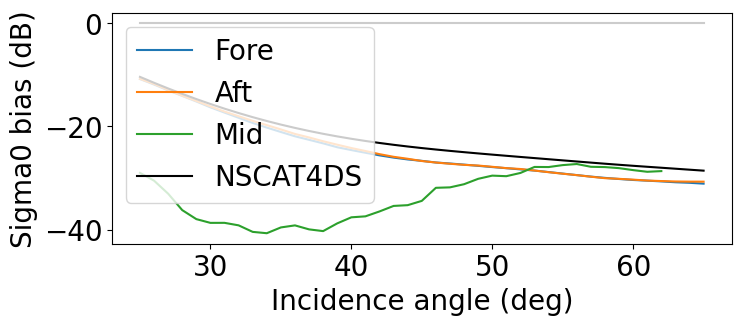

In [58]:
nscat_avg = [np.nan] * np.size(fit.inci.data)
aft_bias = [np.nan] * np.size(fit.inci.data)
mid_bias = [np.nan] * np.size(fit.inci.data)
fore_bias = [np.nan] * np.size(fit.inci.data)
for ii, inci_value in enumerate(fit.inci.data):
    ones = np.ones(np.size(az))
    nscat = 10*np.log10(ss.gmfs.nrcs.nscat4ds(u10*ones, np.abs(np.mod(az - updir +180, 360) - 180),
                inci_value*ones, ones))
    nscat_avg[ii] = np.mean(nscat)
    fore_bias[ii] = np.mean(
        fit_func_simple(az, *fit.sel(Antenna='Fore', inci=inci_value).Sigma0_popt.data),# - nscat
    )
    aft_bias[ii] = np.mean(
        fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value).Sigma0_popt.data),# - nscat
    )
    
    if inci_value <= 62:
        mid_bias[ii] = np.mean(
            fit_func_simple(az, *fit.sel(Antenna='Mid', inci=inci_value).Sigma0_popt.data),# - nscat
        )
fig = plt.figure(figsize=(8, 3))
plt.plot([25,65],[0,0],c=[0.8,0.8,0.8])
plt.xlabel('Incidence angle (deg)', fontsize=20)
plt.ylabel('Sigma0 bias (dB)', fontsize=20)
# sigma0_bias_fore, pcov = curve_fit( 
#                 fit_func_simple, fit.inci.data,  fore_bias,
#                 check_finite=True, 
#                 p0=[-15, 0.02, 0.2, 180], 
#             )
# sigma0_bias_aft, pcov = curve_fit( 
#                 fit_func_simple, fit.inci.data,  aft_bias,
#                 check_finite=True, 
#                 p0=[-15, 0.02, 0.2, 180], 
#             )
# valid = ~np.isnan(mid_bias)
# sigma0_bias_mid, pcov = curve_fit( 
#                 fit_func_simple, fit.inci.data[valid],  np.array(mid_bias)[valid],
#                 check_finite=True, 
#                 p0=[-10, 0.02, 20, 60], 
#             )
# plt.plot(fit.inci.data, fit_func_simple(fit.inci.data, *sigma0_bias_fore.data), color='C0',label='Fore')
# plt.plot(fit.inci.data, fit_func_simple(fit.inci.data, *sigma0_bias_aft.data), color='C1',label='Aft')
# plt.plot(fit.inci.data, fit_func_simple(fit.inci.data, *sigma0_bias_mid.data), color='C2',label='Mid')
plt.plot(fit.inci.data, fore_bias, color='C0',label='Fore')
plt.plot(fit.inci.data, aft_bias, color='C1',label='Aft')
plt.plot(fit.inci.data, mid_bias, color='C2',label='Mid')
plt.plot(fit.inci.data, nscat_avg, color='k',label='NSCAT4DS')
plt.legend()

plt.show()

# Interferometric phase bias

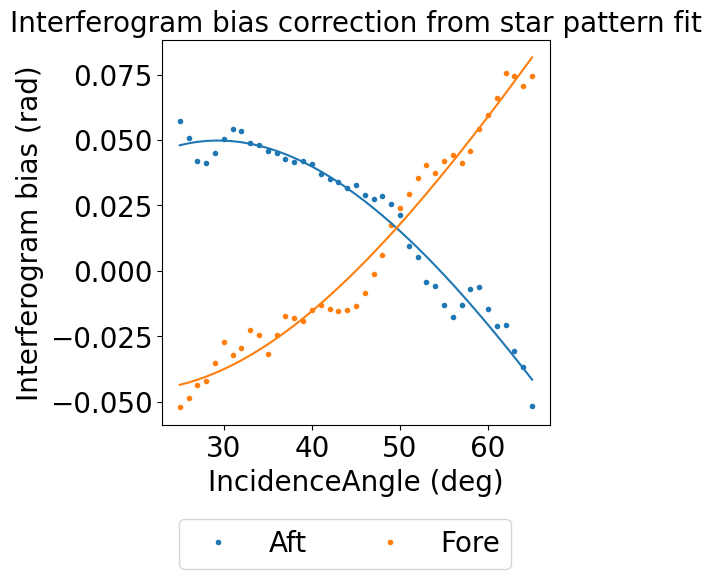

In [50]:
def func(x, a, b, c, d):
    g = (a*x**3) + (b*x**2) + (c*x) + d
    return (g.ravel())

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
IA = fit.Interferogram_popt.sel(parameters='A')
(IA.sel(Antenna='Aft')).plot(label='Aft',marker='.',linestyle='')
(IA.sel(Antenna='Fore')).plot(label='Fore',marker='.',linestyle='')

plt.xlabel('IncidenceAngle (deg)',fontsize=20)
plt.ylabel('Interferogram bias (rad)',fontsize=20)
plt.title('Interferogram bias correction from star pattern fit')
plt.xticks([20,30,40,50,60,70])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,ncol=2,bbox_to_anchor=(0.85,-0.05))

popt_aft, pcov_aft = curve_fit(func,
                       IA.sel(Antenna='Aft').inci.data,
                       IA.sel(Antenna='Aft').data,
                      )
popt_fore, pcov_fore = curve_fit(func,
                       IA.sel(Antenna='Fore').inci.data,
                       IA.sel(Antenna='Fore').data,
                    
                      )
plt.plot(IA.sel(Antenna='Aft').inci.data,
         func(IA.sel(Antenna='Aft').inci.data,
                         *popt_aft), c='C0')
plt.plot(IA.sel(Antenna='Fore').inci.data,
         func(IA.sel(Antenna='Fore').inci.data,
                         *popt_fore), c='C1')

ds_int = xr.Dataset()
interferometric_bias = \
xr.concat([xr.DataArray(data=popt_fore, coords={"parameters": (["parameters"], ["a", "b", "c", "d"])}),
           xr.DataArray(data=popt_aft, coords={"parameters": (["parameters"], ["a", "b", "c", "d"])})],
          dim='Antenna').assign_coords({'Antenna':['Fore','Aft']})
ds_int['bias'] = interferometric_bias
ds_int['func'] = 'g = (a*x**3) + (b*x**2) + (c*x) + d, return (g.ravel())'
# ds_int.to_netcdf('D:\\data\\SEASTAR\\SEASTARex\\Data\\calib\\phase_calib.nc')

# plt.savefig(fig_folder + 'Interferogram_bias_starpattern_land.png', dpi=150, bbox_inches='tight')

# Plot Sigma0

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


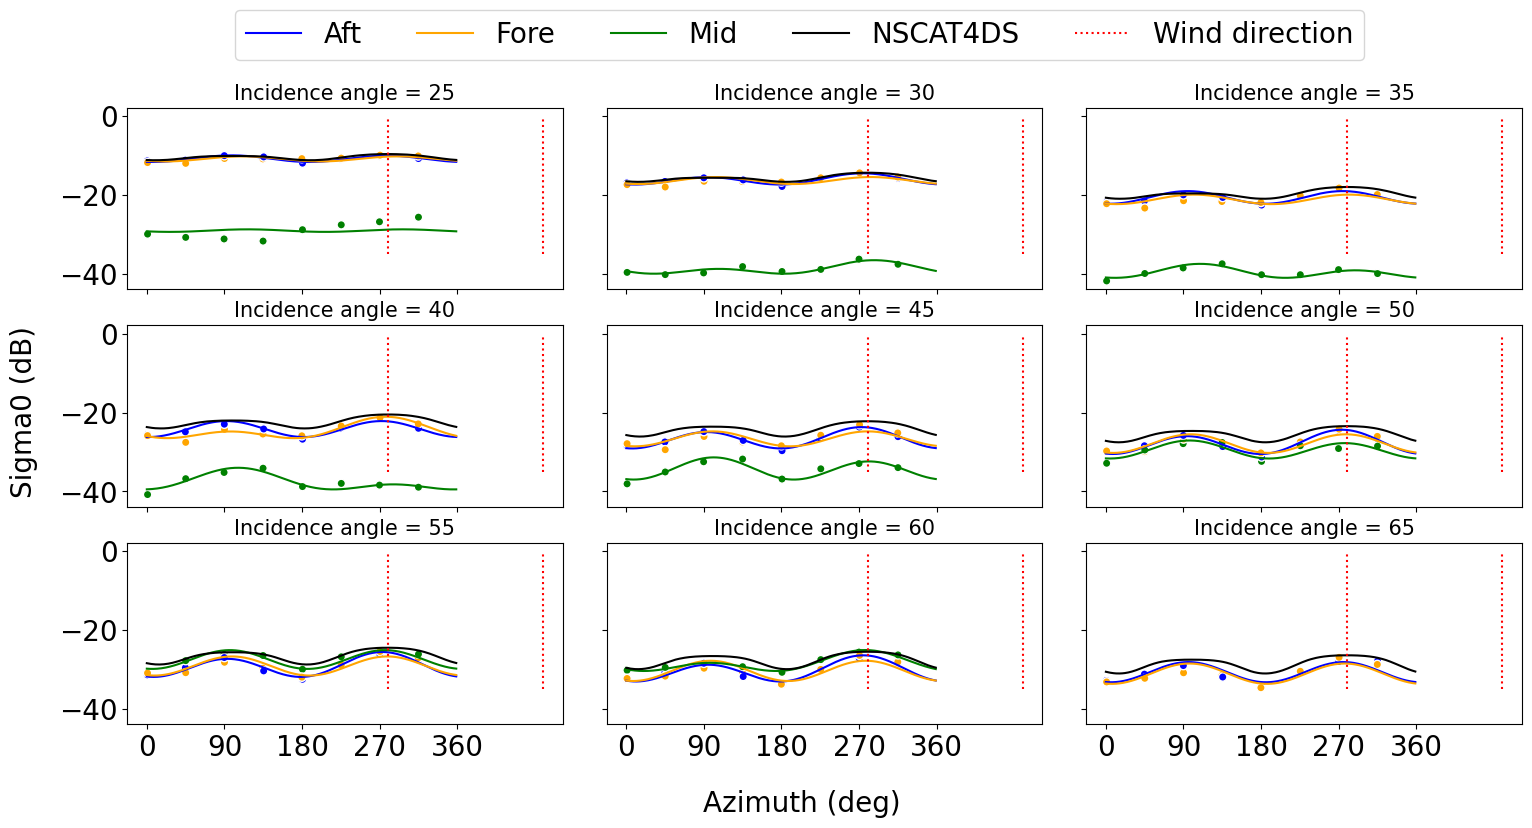

In [51]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,8), sharex=True,
                        sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['blue','orange','green']
ylim=[-35,0]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value)\
        .plot.scatter(x='azimuth',y='Sigma0', hue='Antenna',ax=axs[ii], add_colorbar=False,
                     cmap=mpl.colors.ListedColormap(colors))
    axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value).Sigma0_popt.data),
                 'blue', label='Aft')
    axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Fore', inci=inci_value).Sigma0_popt.data),
                 'orange', label='Fore')
    if inci_value <= 62:
        axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Mid', inci=inci_value).Sigma0_popt.data),
                 'green', label='Mid')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    # plot dummy curve
#     axs[ii].plot(az, fit_func_simple(az, -15, 0.1, 0.2, updir), '--k')
    # plot nscat
    ones = np.ones(np.size(az))
    nscat = 10*np.log10(
            ss.gmfs.nrcs.nscat4ds( 
                u10*ones,
                np.abs(np.mod(az - updir +180, 360) - 180),
                inci_value*ones,
                ones
            )
    )
    axs[ii].plot(az, nscat, 'k',label='NSCAT4DS')
    axs[ii].plot([updir, updir], ylim,'red', label='Wind direction', linestyle='dotted')
    axs[ii].plot([updir+180, updir+180], ylim,'red', linestyle='dotted')
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])          
fig.text(0.5, 0, 'Azimuth (deg)', ha='center')
fig.text(0.06, 0.5, 'Sigma0 (dB)', va='center', rotation='vertical')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5,bbox_to_anchor=(0.82,1.02))
#plt.savefig(fig_folder + 'Intensity.png', dpi=150, bbox_inches='tight')

# Plot Coherence

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: 

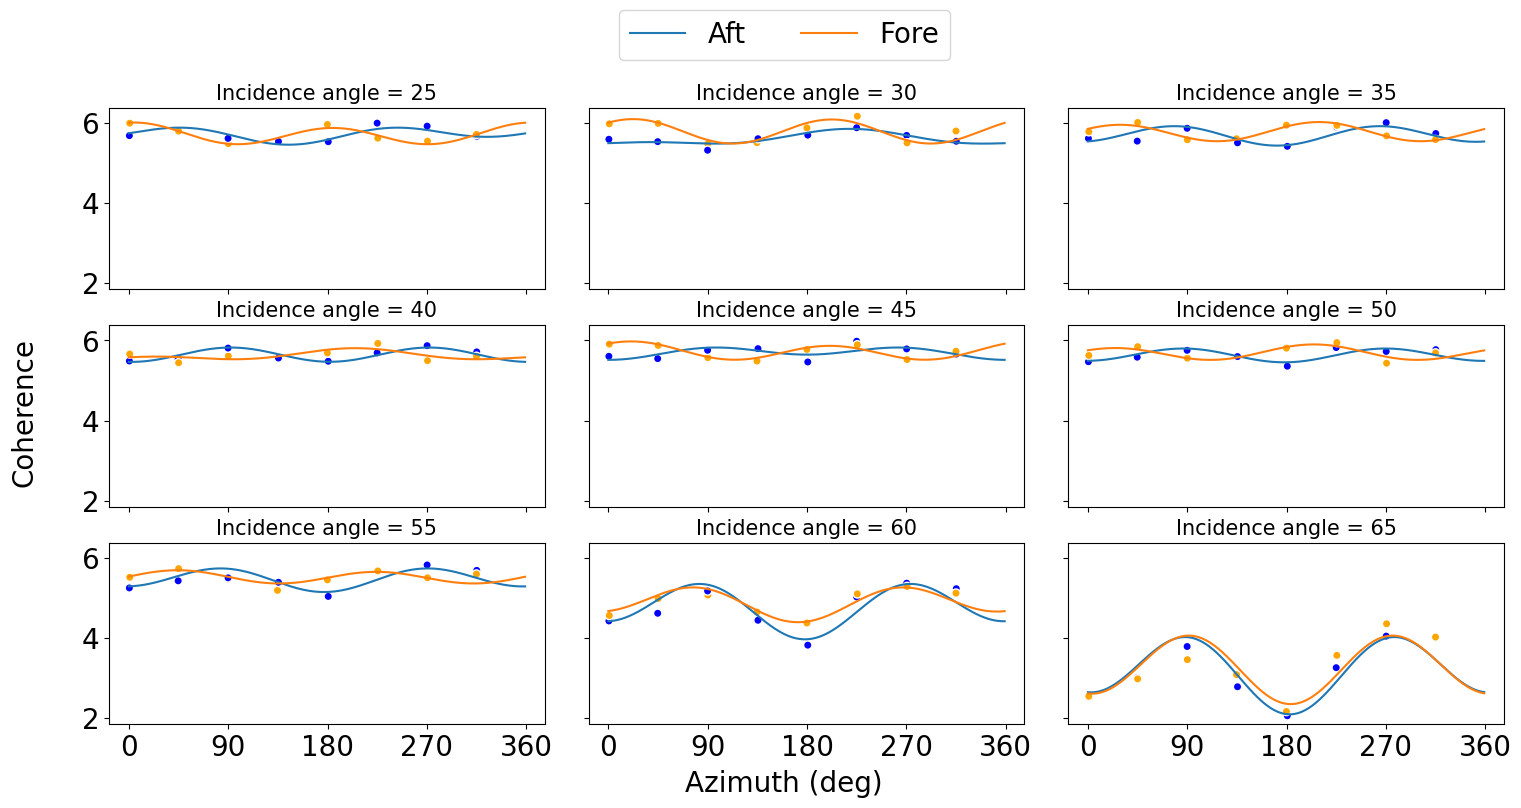

In [52]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,8), sharex=True, sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['blue','orange']
ylim=[0.55,1.01]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value).plot.scatter(x='azimuth',y='Coherence', hue='Antenna',
                                          ax=axs[ii], add_colorbar=False,
                                         cmap=mpl.colors.ListedColormap(colors))
#     axs[ii].plot(az,)
    axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value).Coherence_popt.data),
                 'C0',label='Aft')
    axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Fore', inci=inci_value).Coherence_popt.data),
                 'C1',label='Fore')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    #axs[ii].plot([updir, updir], ylim,'red', label='Wind direction', linestyle='dotted')
    #axs[ii].plot([updir+180, updir+180], ylim,'red', linestyle='dotted')  
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])
    #plt.yticks([0,0.5,1])
fig.text(0.5, 0.025, 'Azimuth (deg)', ha='center')
fig.text(0.07, 0.5, 'Coherence', va='center', rotation='vertical')
handles, labels = axs[ii].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3,bbox_to_anchor=(0.6,1.02))
# plt.savefig(fig_folder + 'Coherence.png', dpi=150, bbox_inches='tight')

# Plot Interferogram

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: 

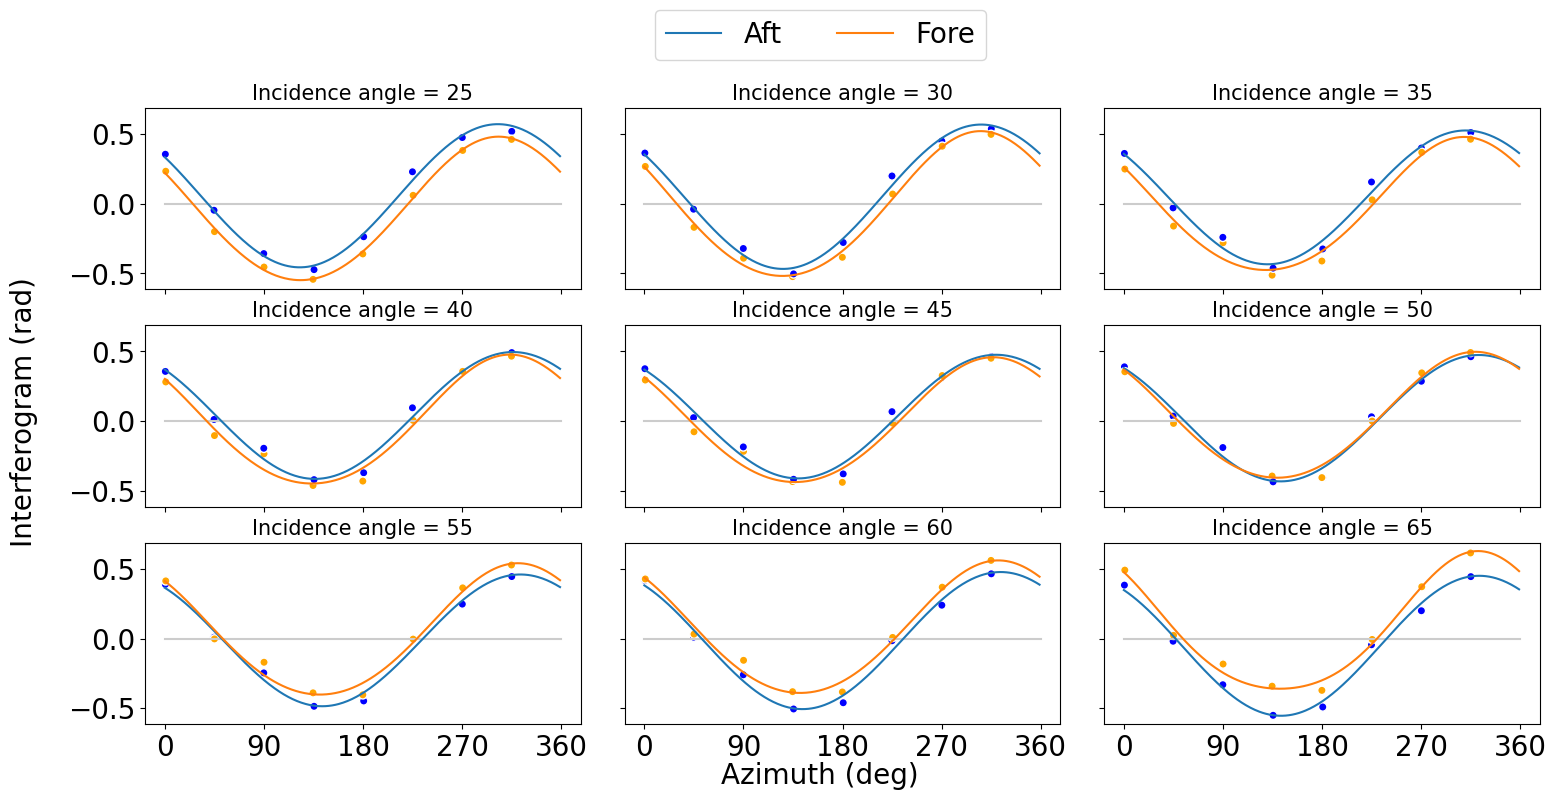

In [53]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,8), sharex=True, sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['blue','orange']
ylim=[-0.28,0.28]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value).plot.scatter(x='azimuth',y='Interferogram', hue='Antenna',
                                          ax=axs[ii], add_colorbar=False,
                                         cmap=mpl.colors.ListedColormap(colors),
                                         )

#     axs[ii].plot(az,)
    axs[ii].plot([0,360],[0,0],c=[0.8,0.8,0.8])
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Aft', inci=inci_value).Interferogram_popt.data),
                 'C0', label='Aft')
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Fore', inci=inci_value).Interferogram_popt.data),
                 'C1', label='Fore')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])
    
fig.text(0.5, 0.035, 'Azimuth (deg)', ha='center')
fig.text(0.05, 0.5, 'Interferogram (rad)', va='center', rotation='vertical')

handles, labels = axs[ii].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2,bbox_to_anchor=(0.6,1.02))
#plt.savefig(fig_folder + 'Interferogram_nocalib.png', dpi=150, bbox_inches='tight')

# Plot WASV

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: 

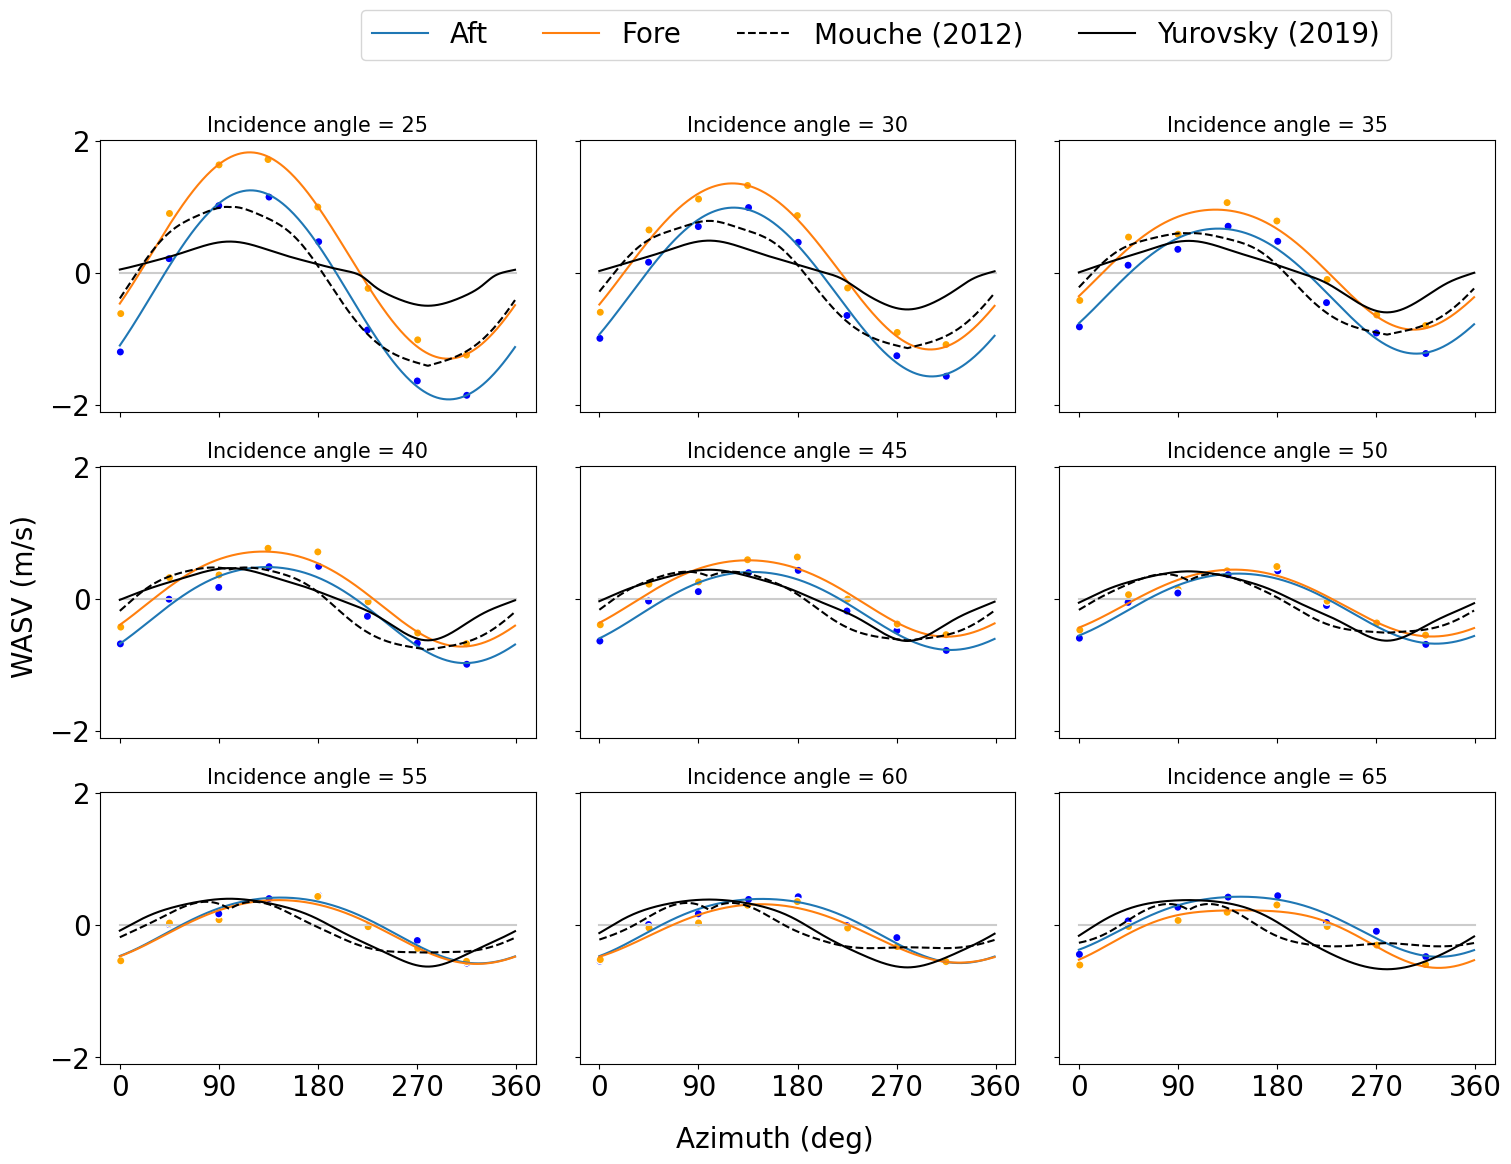

In [54]:
#---------Run ADCP Comparison to colocate ADCP data first---------------
ones = np.ones(np.size(az))
# H0_sw = aux_list['Trefle_spectra'].Hm0\
#     .sel(spec_time=ds_L1c[track].TrackTime.sel(Antenna='Mid').data, method='nearest').data
# f_sw = aux_list['Trefle_spectra'].f[
#     np.argmax(aux_list['Trefle_spectra'].Szz.sel(spec_time=ds_L1c[track].TrackTime.sel(Antenna='Mid').data,
#                                                  method='nearest').data)]
# Om_sw = (2 * np.pi) / (1 / f_sw)
# dir_sw = aux_list['Trefle_MEM'].nazim[
#     np.argmax(aux_list['Trefle_MEM'].sel(ntime=ds_L1c[track].TrackTime.sel(Antenna='Mid').data, method='nearest')\
#     .MEM\
#     .sel(nfreq=f_sw, method='nearest').data)].data
# P_sw = np.mod(dir_sw + 180, 360)


fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,12), sharex=True, sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['blue','orange']

ylim=[-1,1]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value).plot.scatter(x='azimuth',y='WASV', hue='Antenna',
                                          ax=axs[ii], add_colorbar=False,
                                         cmap=mpl.colors.ListedColormap(colors),
                                         )
    
    
    axs[ii].plot([0,360],[0,0],c=[0.8,0.8,0.8])
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Aft', inci=inci_value).WASV_popt.data),
                  'C0', label='Aft')
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Fore', inci=inci_value).WASV_popt.data),
                 'C1', label='Fore')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])
    dop_c = ss.gmfs.doppler.mouche12(u10*ones,
                                    np.abs(np.mod(az - updir +180, 360) - 180),
                                    inci_value*ones,
                                    'VV')
    f_c = 5.5 * 10 ** 9
    dop_Hz = dop_c * ds_L1c['Track_11'].CentralFreq.data[0] / f_c
    [wasv_losv, wasv_mouche12] = ss.gmfs.doppler.convertDoppler2Velocity(
                ds_L1c['Track_11'].CentralFreq.data[0] / 1e9,
                dop_Hz,
                inci_value*ones
            )
    axs[ii].plot(az,  wasv_mouche12, 'k', linestyle='dashed', label='Mouche (2012)')
    [wasv_yurovsky, dc_HH] = ss.gmfs.doppler.yurovsky19(
            inci_value*ones,
            np.abs(np.mod(az - updir +180, 360) - 180),
            u10*ones,
            lambdar=(1 / ds_L1c['Track_11'].CentralFreq.data[0]) * sp.constants.c,
        )
#     [wasv_yurovsky_wave, dc_HH] = ss.gmfs.doppler.yurovsky19(
#             inci_value*ones,
#             np.abs(np.mod(az - updir +180, 360) - 180),
#             u10*ones,
#             swh_sw=H0_sw,
#             omega_sw=Om_sw,
#             phi_sw=P_sw,
#             lambdar=(1 / ds_L1c['Track_11'].CentralFreq.data[0]) * sp.constants.c,
#         )


    axs[ii].plot(az,  wasv_yurovsky, 'k', label='Yurovsky (2019)')
#     axs[ii].plot(az,  -wasv_yurovsky, 'k', linestyle='dotted', label='Yurovsky waves')
    #axs[ii].plot([updir, updir], ylim,'red', label='Wind direction', linestyle='dotted')
    #axs[ii].plot([updir+180, updir+180], ylim,'red', linestyle='dotted') 
    #axs[ii].plot([np.mean(dir_adcp), np.mean(dir_adcp)], ylim, 'purple',linestyle='dotted')
#     axs[ii].plot(az, -ADCP, 'purple', label='ADCP')
    


fig.text(0.5, 0.04, 'Azimuth (deg)', ha='center')
fig.text(0.075, 0.5, 'WASV (m/s)', va='center', rotation='vertical')

handles, labels = axs[ii].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5,bbox_to_anchor=(0.85,1.0))
#plt.savefig(fig_folder + 'WASV_nocalib_oldsign_wind.png', dpi=150, bbox_inches='tight')

# RSC

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: 

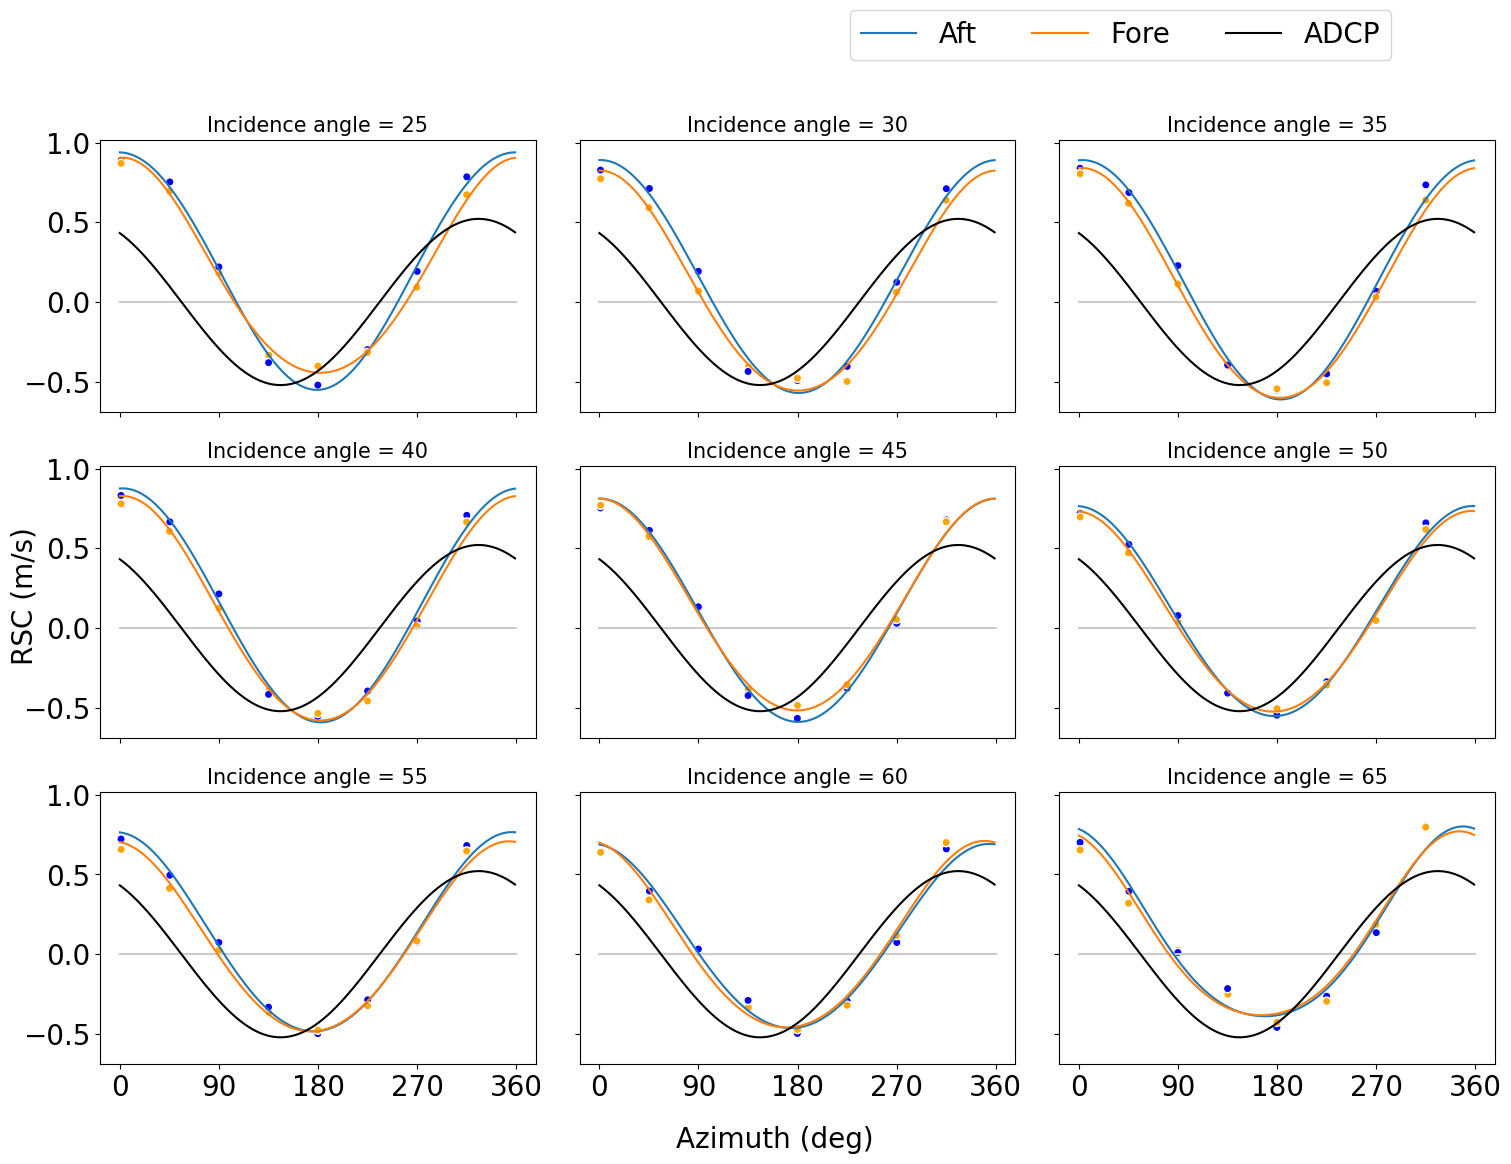

In [18]:
ones = np.ones(np.size(az))
ADCP = - np.mean(U_adcp) * np.cos(np.radians(az-np.mean(dir_adcp)))

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,12), sharex=True, sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['blue','orange']

ylim=[-1,1]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value).plot.scatter(x='azimuth',y='RadialSurfaceCurrent', hue='Antenna',
                                          ax=axs[ii], add_colorbar=False,
                                         cmap=mpl.colors.ListedColormap(colors),
                                         )
    
    
    axs[ii].plot([0,360],[0,0],c=[0.8,0.8,0.8])
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Aft', inci=inci_value).RSC_popt.data),
                  'C0', label='Aft')
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Fore', inci=inci_value).RSC_popt.data),
                 'C1', label='Fore')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])

    axs[ii].plot(az, -ADCP, 'black', label='ADCP')
    


fig.text(0.5, 0.04, 'Azimuth (deg)', ha='center')
fig.text(0.075, 0.5, 'RSC (m/s)', va='center', rotation='vertical')

handles, labels = axs[ii].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5,bbox_to_anchor=(0.85,1.0))
#plt.savefig(fig_folder + 'WASV_nocalib_oldsign_wind.png', dpi=150, bbox_inches='tight')